In [179]:
import git
import os
import pandas as pd
from glob import glob
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# COVID-19

### Update the data source
The data source is a repository by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE): [Johns Hopkins Github repository](https://github.com/CSSEGISandData/COVID-19).

We want to make the pull in the easiest and fastest possible way, so I make the next script for that:

Update the data sources pulling the [Johns Hopkins repository](https://github.com/CSSEGISandData/COVID-19).

In [253]:
# update data source
git_local_path = 'C:\\Users\\nieto\\Google Drive\\COVID19\\CSSEGISandData_COVID-19'

git_repo_path = 'https://github.com/CSSEGISandData/COVID-19.git'

g = git.cmd.Git(git_local_path)

g.pull(git_repo_path)

'Updating a7f6c19..8d7bdf1\nFast-forward\n .../csse_covid_19_daily_reports/03-22-2020.csv     | 3728 ++++++++++++++++++--\n .../20200324-sitrep-64-covid-19.pdf                |  Bin 0 -> 1169027 bytes\n 2 files changed, 3418 insertions(+), 310 deletions(-)\n create mode 100644 who_covid_19_situation_reports/who_covid_19_sit_rep_pdfs/20200324-sitrep-64-covid-19.pdf'

In [254]:
# path to the data sources
path_time_series = 'CSSEGISandData_COVID-19\\csse_covid_19_data\\csse_covid_19_time_series'

# file names
file_confirmed = 'time_series_covid19_confirmed_global'
file_deaths = 'time_series_covid19_deaths_global'
file_recovered = 'time_series_19-covid-Recovered'

# read our data
Confirmed = pd.read_csv(path_time_series+'\\'+file_confirmed+'.csv')
Deaths = pd.read_csv(path_time_series+'\\'+file_deaths+'.csv')
Recovered = pd.read_csv(path_time_series+'\\'+file_recovered+'.csv')

# list of the countries that have confirmed cases
Countries = list(Confirmed['Country/Region'].unique())
Countries.sort()

# in this index, the columns of our sources begin to be dates
start_index = 1

# columns of hour data
Columns = Confirmed.columns.to_list()

### Functions

In [503]:
# useful functions

def cols_to_datetime(dataframe,start_index=None,string=False):
    """Returns columns of time series in pandas datetimes
    
    Args:
        dataframe,
            dataframe of the time series.
        start_index,
            int can be null, in this index the date columns start to appear.
        string:
            bool default False, if True the desired output is in strings 
            
    Returns:
        list of strings or array with datetimes
    """
    
    cols = dataframe.columns.to_list()
    if start_index!=None:
        new_cols = pd.to_datetime(cols[start_index:])
        
        if string: # if output format is string 
            new_cols = list(map(str,new_cols))
            new_cols = [date.split()[0] for date in new_cols]
            cols[start_index:] = new_cols
            return cols
        
        else: # if output format is in pandas datetime
            cols[start_index:]=new_cols
            return cols
        
    else:
        new_cols = pd.to_datetime(cols)
        
        if string: # if output format is string 
            new_cols = list(map(str,new_cols))
            new_cols = [date.split()[0] for date in new_cols]
            cols = new_cols
            return cols
        
        else: # if output format is in pandas datetime
            cols=new_cols
            return cols
        
        
def transform_cols(dataframe,start_index=None):
    
    """Transform and correct the date strings columns in the data frame from 'm/d/y'
    to 'yyyy-mm-dd' to have homogeneous date columns.
    
    Args:
        dataframe,
            we are going to transform the columns of this pandas dataframe
        start_index,
            int can be null, in this index the date columns start to appear
        
    Returns:
        pandas dataframe
    """
    
    cols = dataframe.columns.to_list()
    new_cols = cols_to_datetime(dataframe,start_index=start_index,string=True)
    d = dict(zip(cols,new_cols))
    result = dataframe.rename(d,axis=1)
    return result

def get_last_update_date(timeseries, start_index=None, string=False):
    
    """Returns the last update date of a time series.
    
    Args:
        timeseries:
            DataFrame
            
        start_index,
            int can be null, in this index the date columns start to appear.
        
        string:
            bool default False, if True the desired output is in strings 
    Returns:
        str or datetime, last update date of the time series
    """
    
    if start_index!=None:
        dates = cols_to_datetime(timeseries,start_index)
        dates = dates[start_index:]
        last_update = max(dates)

        if string:
            last_update = str(last_update).split()[0]
            return last_update
        
        else:
            return last_update
        
    else:
        dates = cols_to_datetime(timeseries)
        last_update = max(dates)

        if string:
            last_update = str(last_update).split[0]
            return last_update
        
        else:
            return last_update

        
def get_ts_values(timeseries,start_index=None):
    """Returns the numeric values of a time series in a numpy array
    
    Args:
        timeseries:
            dataframe of timeseries
        
        start_index,
            int default null, in this index the date columns start to appear.
            
    Returns:
        numpy array
    """
    if start_index==None:
        dates = get_dates(timeseries)
        values = timeseries[dates].to_numpy()

        if len(values)==1:
            return values[0]

        else:
            return values
        
    else:
        dates = get_dates(timeseries,start_index=start_index)
        values = timeseries[dates].to_numpy()

        if len(values)==1:
            return values[0]

        else:
            return values
    
def get_dates(timeseries,start_index=None):
    """Returns the dates of the time series columns
    
    Args:
        timeseries:
            dataframe of timeseries
        
        start_index,
            int not null, in this index the date columns start to appear.
    
    Returns:
        list
    """
    if start_index!=None:
        dates = cols_to_datetime(dataframe=timeseries,
                                start_index=start_index,
                                string=True)
        dates = dates[start_index:]

        return dates
    
    else:
        dates = cols_to_datetime(dataframe=timeseries,
                                start_index=None,
                                string=True)
        
        return dates
#def get_actual_value(df):

def make_country_time_series(name,data):
    """This function helps to get the transformed (see: transform_cols function) time series grouped by 
    'Country/Region' the correspondent data.
    
    Note: also drops the 'Lat' and 'Long' columns.
    
    Args:
        name:
            str not null, name of the country with first capital letter
        
        data:
            dataframe not null, data of the time series. 
            It can be: Confirmed/Deaths/Recovered
            
    """
    df = data[data['Country/Region']==name].groupby('Country/Region').sum()
    df.drop(['Lat','Long'],axis=1,inplace=True)
    df = transform_cols(df)
    return df

def consolidate_time_series(array):
    """Consolidate different time series and drop all the columns with zeros in order
    to help us make better charts and have a better insight of the date of the first
    confirmed case.
    
    Args:
        array: 
        not null, list or array like object of the time series to consolidate.
        
    Returns:
        dataframe
        
    """
    df = pd.concat(array)
    df = df.replace({0:np.nan})
    df.dropna(axis=1,thresh=1,inplace=True)
    return df

def get_global(kind='Confirmed'):
    """Gets global time series of the desired kind.
    
    Args:
        kind:
            string default 'Confirmed',
            options: ['Confirmed','Deaths','Recovered']
    
    Returns:
        dataframe
        
    """
    if kind.lower()=='confirmed':
        df = Confirmed.groupby(lambda x: True).sum()
        new_cols = cols_to_datetime(df,start_index=2)[2:]
        df.drop(['Lat','Long'],inplace=True,axis=1)
        df.rename(dict(zip(df.columns.to_list(),new_cols)),axis=1,inplace=True)
        df.rename({True:'Global'}, axis=0,inplace=True)
        return df
    
    elif kind.lower()=='deaths':
        df = Deaths.groupby(lambda x: True).sum()
        new_cols = cols_to_datetime(df,start_index=2)[2:]
        df.drop(['Lat','Long'],inplace=True,axis=1)
        df.rename(dict(zip(df.columns.to_list(),new_cols)),axis=1,inplace=True)
        df.rename({True:'Global'}, axis=0,inplace=True)
        return df
    
    elif kind.lower()=='recovered':
        df = Recovered.groupby(lambda x: True).sum()
        new_cols = cols_to_datetime(df,start_index=2)[2:]
        df.drop(['Lat','Long'],inplace=True,axis=1)
        df.rename(dict(zip(df.columns.to_list(),new_cols)),axis=1,inplace=True)
        df.rename({True:'Global'}, axis=0,inplace=True)
        return df
    else:
        error = """Please enter a valid kind.
        valid kinds:
            ['Confirmed','Deaths','Recovered']
        """
        print(error)
        raise
        
def get_deltas(timeseries):
    """compute deltas in a time series dataframe
    
    Arg:
        timeseries not null
    """
    deltas = timeseries.diff(axis=1)/timeseries
    return deltas


def get_top_values(kind='Confirmed',top=10,ascending=True):
    """gets top values for a desired kind of information.
    
    Args:
        kind:
            string default 'Confirmed',
            options: ['Confirmed','Deaths','Recovered','Deltas-mean']
        top:
            int default 10, number of elements you want to get
        ascending:
            bool default True, if True then we are going to get the top
            in ascending order (minimun values), if false we get the
            maximun values.
    
    Returns:
        tuple of dataframes
            df1: 
                top10
            df2:
                complete df with all values
    """
    
    if kind.lower() == 'confirmed':
        vals = []
        for country in Countries:
            vals.append(Country(country).get_actual_confirmed()[0])
            
        df = pd.DataFrame({kind:vals}, index=Countries)
        df2 = df.sort_values(by=kind,axis=0,ascending=ascending).head(top)
        return df2,df
    
    elif kind.lower() == 'deaths':
        vals = []
        for country in Countries:
            vals.append(Country(country).get_actual_deaths()[0])
        
        df = pd.DataFrame({kind:vals}, index=Countries)
        df2 = df.sort_values(by=kind,axis=0,ascending=ascending).head(top)
        return df2,df
    
    elif kind.lower() == 'recovered':
        vals = []
        for country in Countries:
            vals.append(Country(country).get_actual_recovered()[0])
        
        df = pd.DataFrame({kind:vals}, index=Countries)
        df2 = df.sort_values(by=kind,axis=0,ascending=ascending).head(top)
        return df2,df

    elif kind.lower() == 'deltas-mean':
        vals=[]
        for country in Countries:
            vals.append(get_deltas(Country(country).get_confirmed_ts()).loc[country].mean())
        
        df = pd.DataFrame({kind:vals},index=Countries)
        df2 = df.sort_values(by=kind,axis=0,ascending=ascending).head(top)
        return df2,df
    
    else:
        error = """Please enter a valid kind.
        valid kinds:
            ['Confirmed','Deaths','Recovered']
        """
        print(error)
        raise

### Classes

In [256]:
class Country:
    
    def __init__(
        self,
        name,
        time_series_confirmed=None,
        time_series_deaths=None,
        time_series_rec=None
    ):
        
        if not name in Countries:
            error_name='''Invalid country name, please validate your input
or capitalize the first letter of the country name.
            \nExample: china -> China'
            For United States use 'US'
            '''
            print(error_name)
            raise
            
        else:
            self.name = name
            self.time_series_confirmed = make_country_time_series(self.name,Confirmed)
            self.time_series_deaths = make_country_time_series(self.name,Deaths)
            self.time_series_rec = make_country_time_series(self.name,Recovered)
     
    
    def get_confirmed_ts(self,):
        ts = self.time_series_confirmed
        #drop_zeros(ts)
        return self.time_series_confirmed
    
    def get_death_ts(self):
        return self.time_series_deaths
    
    def get_rec_ts(self):
        return self.time_series_rec
    
    def get_actual_confirmed(self):
        #print('Actual confirmed cases in '+self.name+':')
        return self.get_actual_value('confirmed')
    
    def get_actual_deaths(self):
        #print('Actual deaths number in '+self.name+':')
        return self.get_actual_value('deaths')
    
    def get_actual_recovered(self):
        #print('Actual recovered number in '+self.name+':')
        return self.get_actual_value('rec')
    
    def get_actual_value(self,value='confirmed'):
        """returns the actual value of a desired time series.
        
        Args:
            value:
                str, desired value we desire
                'confirmed' for confirmed
                'deaths' for deaths
                'rec' for recovered
        Returns:
            int, number of confirmed/deaths/recovered
        """
        valid_values = ['confirmed','deaths','rec']
        dfs = [self.time_series_confirmed,self.time_series_deaths,self.time_series_rec]
        d = dict(zip(valid_values,dfs))
        
        if value.lower() in valid_values:
            ts = d[value.lower()]
            ts = ts.groupby('Country/Region').sum()
            last_update = get_last_update_date(ts,start_index=start_index,string=True)
            return ts[last_update]
        
        else:
            error = """ Please enter a valid value:
            valid values:
                'confirmed' for confirmed
                'deaths' for deaths
                'rec' for recovered
            """
            print(error)
            raise
            
    def get_mortality_rates(self):
        """
        """
        confirmed = get_ts_values(self.time_series_confirmed.groupby('Country/Region').sum())
        deaths = get_ts_values(self.time_series_deaths.groupby('Country/Region').sum())
        mortality_rates = deaths/confirmed
        ix = get_dates(self.time_series_confirmed.groupby('Country/Region').sum())
        mortality_rates = pd.Series(data=mortality_rates,index=ix)
        return mortality_rates
    
    def get_actual_mortality_rate(self):
        """
        """
        return self.get_mortality_rates()[-1]

### Get actual values of a country

> **Note:** if you want to see the list of countries available run a code cell with ``Countries``

**Get actual confirmed** 

In [266]:
Country('India').get_actual_confirmed()

Country/Region
India    536
Name: 2020-03-24, dtype: int64

**Get actual deaths cases**

In [258]:
Country('San Marino').get_actual_deaths()

Country/Region
San Marino    21
Name: 2020-03-24, dtype: int64

**Get actual recovered cases**

In [259]:
Country('San Marino').get_actual_recovered()

Country/Region
San Marino    4.0
Name: 2020-03-23, dtype: float64

**Get actual mortality rate**

In [260]:
Country('San Marino').get_actual_mortality_rate()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning:

invalid value encountered in true_divide



0.11229946524064172

### Get and make the curve of the time series of a country

First, **we can display the DataFrame with the time series of a Country**

In [261]:
# ts for TimeSeries
ts = Country('China').get_confirmed_ts()
ts

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,...,81003,81033,81058,81102,81156,81250,81305,81435,81498,81591


In [262]:
y = get_ts_values(ts)
x = ts.columns.to_list()

fig = go.Figure(
    go.Scatter(
        name='China',
        mode='lines+markers',
        x=x,
        y=y,
        line=dict(
            color='firebrick'
        )
    )
)

# layout
fig.update_layout(
    title='Confirmed cases in China',
    xaxis_title="Date",
    yaxis_title=None,
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    )
)

fig.show()

### Compare different time series

In [265]:
# consolidate 3 time series
# see func 'consolidate_time_series(array)'
ts1 = Country('Mexico').get_confirmed_ts()
ts2 = Country('Brazil').get_confirmed_ts()
ts3 = Country('Chile').get_confirmed_ts()
conso = consolidate_time_series([ts1,ts2,ts3])

y1 = conso.loc['Mexico']
y2 = conso.loc['Brazil']
y3 = conso.loc['Chile']
x = conso.columns.to_list()

fig = go.Figure()

fig.add_trace(go.Scatter(name='Brazil',x=x,y=y2,mode='lines+markers',line=dict(color='firebrick'),
                        text=y2))
fig.add_trace(go.Scatter(name='Mexico',x=x,y=y1,mode='lines+markers',line=dict(color='steelblue',width=2)))
fig.add_trace(go.Scatter(name='Chile',x=x,y=y3,mode='lines+markers',line=dict(color='darkgreen')))

# layout
fig.update_layout(
    title='Confirmed cases in Mexico, Brazil and Chile',
    xaxis_title="Date",
    yaxis_title="Confirmed Cases",
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    ),
    annotations=[
        dict(
            x=x[-1],
            y=y2[-1],
            xref="x",
            yref="y",
            text='{}'.format(int(y2[-1])),
            showarrow=True,
            arrowhead=7
        ),
        dict(
            x=x[-1],
            y=y1[-1],
            xref="x",
            yref="y",
            text='{}'.format(int(y1[-1])),
            showarrow=True,
            arrowhead=7
        ),
        dict(
            x=x[-1],
            y=y3[-1],
            xref="x",
            yref="y",
            text='{}'.format(int(y3[-1])),
            showarrow=True,
            arrowhead=7
        )
    ]
)
fig.show()

**We can automate the annotations with the code below**

As we saw in the examples above, we can put annotations in the chart, but note in the last code cell we actually coded a lot of lines only to annotate the last values of the time series.

So in the code cell below is an example of how to write annotations in the chart with a **``for loop``**.

In [274]:
# consolidate 3 time series
# see func 'consolidate_time_series(array)'
ts1 = Country('US').get_confirmed_ts()
ts2 = Country('China').get_confirmed_ts()
ts3 = Country('Iran').get_confirmed_ts()
ts4 = Country('Italy').get_confirmed_ts()
conso = consolidate_time_series([ts1,ts2,ts3,ts4])

# get values
y1 = conso.loc['US']
y2 = conso.loc['China']
y3 = conso.loc['Iran']
y4 = conso.loc['Italy']
y_list = [y1,y2,y3,y4]
x = conso.columns.to_list()

fig = go.Figure()

# add lines
fig.add_trace(go.Scatter(name='China',x=x,y=y2,mode='lines+markers',line=dict(color='firebrick'),
                        text=y2))
fig.add_trace(go.Scatter(name='US',x=x,y=y1,mode='lines+markers',line=dict(color='steelblue',width=2)))
fig.add_trace(go.Scatter(name='Iran',x=x,y=y3,mode='lines+markers',line=dict(color='darkgreen',width=2)))
fig.add_trace(go.Scatter(name='Italy',x=x,y=y4,mode='lines+markers',line=dict(width=2)))

# automate annotations
annotations = []
for yi in y_list:
    annotations.append(
        dict(
            x=x[-1],
            y=yi[-1],
            xref="x",
            yref="y",
            text='{}'.format(int(yi[-1])),
            showarrow=True,
            arrowhead=7
        )
    )
    
# layout
fig.update_layout(
    title='Confirmed cases in US, China and Iran',
    xaxis_title="Date",
    yaxis_title="Confirmed Cases",
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    ),
    annotations=annotations
)

fig.show()

**What if we liked to display a lot of time series in one chart?**

We likely code a lot of code lines as in the examples above, but if we manage to make a function to do all of that code for us, will be awesome!

In the cell below is a function that automates the plot's of multiple time series.

In [593]:
def graph_lines(countries,kind='Confirmed'):
    """Graph a line chart for every time serie of the countries passed in.
    
    Args:
        countries:
            list or array like object, list of countries to plot time series
        
        kind:
            str default 'Confirmed', kind of data we want to plot.
    
    Returns:
        nothing, it displays the plot and save it to a local path called figs/file_name.png
    """
    
    # store every time series for each country
    # for the kind specified
    ts = []
    if kind.lower() == 'confirmed':
        for country in countries:
            ts.append(Country(country).get_confirmed_ts())
    
    elif kind.lower() == 'deaths':
            for country in countries:
                ts.append(Country(country).get_death_ts())
                
    elif kind.lower() == 'recovered':
            for country in countries:
                ts.append(Country(country).get_rec_ts())
    
    else:
        error ="""kind not valid, please enter one of this:
        
        valid kinds:
            ['Confirmed', 'Deaths', 'Recovered']
            
        """
        print(error)
        raise
    
    # consolidate the time series in a dataframe
    conso = consolidate_time_series(ts)
    
    # get x and y values for the plot
    x = conso.columns.to_list()
    y = []
    for country in conso.index.to_list():
        y.append(conso.loc[country])
    
    # initialize plotly figure and
    # add the lines for each country
    fig = go.Figure()
    for i in range(len(countries)):
        fig.add_trace(go.Scatter(name=countries[i],x=x,y=y[i],mode='lines+markers',line=dict(width=2)))
    
    # store the annotations
    annotations = []
    for yi in y:
        annotations.append(
            dict(
                x=x[-1],
                y=yi[-1],
                xref="x",
                yref="y",
                text='{}'.format(int(yi[-1])),
                showarrow=True,
                arrowhead=7
            )
        )
    
    # store strings for title and file name
    strings = [] # for title
    strings2 = [] # for file name
    if len(countries)!=1:
        for i in range(len(countries)):
            if i==(len(countries)-1):
                strings.append('and '+countries[i])
                strings2.append(countries[i])

            else:
                strings.append(countries[i]+', ')
                strings2.append(countries[i])
    
    else:
        strings.append(countries[0])
        strings2.append(countries[0])
    
    # title for layout
    title = 'Confirmed cases in '+ ''.join(strings)
    
    # layout
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Confirmed Cases",
        font=dict(
            family="Arial, bold",
            size=14,
            #color="auto"
        ),
        annotations=annotations
    )
    
    # filename for saving plot
    file_name = 'lines_'+kind+'_'.join(strings2)+'.png'
    
    fig.write_image("figs/"+file_name)
    fig.show()

In [594]:
graph_lines(['US','Spain','China','Italy'],kind='deaths')

In [304]:
graph_lines(['US','Italy','Iran','Germany','China','Canada','Poland','Spain','Netherlands', 'United Kingdom'])

10
10


In [307]:
# we also can plot only 1 time series
graph_lines(['Mexico'])

### Confirmed cases

All this plots that we have done are from the confirmed cases, but what are the confirmed cases?

**Confirmed cases are all the cumulative positive coronavirus cases that a country oficialy reports**

We can use de method ``get_confirmed_ts()`` in the class ``Country()`` to get the confirmed cases time series of a country, or you can simply use the method ``get_actual_confirmed()`` to get the confirmed cases at the last update date.

In [358]:
# we can get the global time series
# see get_global in functions.
g_confirmed = get_global('Confirmed')
g_confirmed

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24
Global,555,654,941,1434,2118,2927,5578,6166,8234,9927,...,167454,181573,197150,214909,242706,272164,304519,337089,378547,418678


In [359]:
# or we can get the actual global confirmed cases
last_update_date = cols_to_datetime(g_confirmed).max()
g_confirmed[last_update_date]

Global    418678
Name: 2020-03-24 00:00:00, dtype: int64

In [487]:
# we can plot thi global time series

y = g_confirmed.to_numpy()[0]
x = g_confirmed.columns.to_list()

fig = go.Figure(
    go.Scatter(
        name='Global',
        mode='lines+markers',
        x=x,
        y=y,
        line=dict(
            color='firebrick'
        )
    )
)

fig.update_layout(
    title='Global Confirmed Cases',
    xaxis_title="Date",
    yaxis_title="Confirmed Cases",
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    ),
    annotations=[
        dict(
            x=x[-1],
            y=y[-1],
            xref="x",
            yref="y",
            text='{}'.format(int(y[-1])),
            showarrow=True,
            arrowhead=7
        )
    ]
)
fig.write_image("figs/line_global_confirmed.png")
fig.show()

### Distribution of confirmed cases per country

**Which are the countries with the most cases in the world?**

To answer this, we can do the following:

In [482]:
# get the top values, see functions for details
top10,df = get_top_values(kind='Confirmed',top=10,ascending=False)

In [484]:
top10

,Confirmed
China,81591
Italy,69176
US,53740
Spain,39885
Germany,32986
Iran,24811
France,22622
Switzerland,9877
"Korea, South",9037
United Kingdom,8164


In [488]:
# we can plot this in a bar plot
y = top10['Confirmed'][::-1]
x = top10.index.to_list()[::-1]

fig = go.Figure(
    data=[
        go.Bar(
            x=y,
            y=x,
            orientation='h'
        )
    ]
)

fig.update_traces(
    marker_color='rgb(172,24,24)',
    marker_line_color='rgb(33,35,59)',
    marker_line_width=1.5,
    opacity=0.8
)

annotations=[]
for yi,xi in zip(y,x):
    annotations.append(
        dict(
            x=yi,
            y=xi,
            #xref="x",
            #yref="y",
            text='{}'.format(int(yi)),
            xshift=23,
            showarrow=False,
            #arrowhead=7
        )
    )

fig.update_layout(
    title='Global Confirmed Cases',
    xaxis_title="Date",
    yaxis_title="Confirmed Cases",
    font=dict(
        family="Arial, bold",
        size=14,
        #color="auto"
    ),
    annotations=annotations
)
fig.write_image("figs/bar_top10_confirmed.png")
fig.show()


With this information we could answer the question: **How fast the virus is spreading globally?**

The answer is easy, supose that we have defined $\delta$ as the increment in % from a value in time respect the previous values, i.e:

$$
\delta_i = \frac{t_{i}-t_{i-1}}{t_i}
$$

where $t_i$ is the value of our time series in the time $i$.

In [524]:
deltas = get_deltas(g_confirmed)
#get the mean of the deltas
deltas_mean = deltas.loc['Global'].mean()

print("In average, the confirmed cases are increasing in: {0:.2f}% globally every day.".format(deltas_mean*100))

In average, the confirmed cases are increasing in: 9.51% globally every day.


Now, **What Country is increasing the most in average daily?**

In [516]:
top10,df = get_top_values(kind='deltas-mean',top=10,ascending=False)

In [523]:
top10

,deltas-mean
Laos,1.000000
Libya,1.000000
Mozambique,0.555556
Belize,0.500000
Dominica,0.500000
Uganda,0.472222
Turkey,0.430178
Madagascar,0.408824
Kyrgyzstan,0.402211
Mauritius,0.393991


In [526]:
graph_lines(['Mozambique','Laos','Belize'])

As we can see above, the countries with almost no data is making our data dirty, so we need to exclude those countries with little data.

In [517]:
excluded_countries = list(Confirmed[Confirmed["3/23/20"]<200]['Country/Region'].unique())
df.drop(excluded_countries,axis=0,inplace=True)

,deltas-mean
Algeria,0.185115
Argentina,0.253490
Armenia,0.208247
Austria,0.259671
Bahrain,0.148995
Belgium,0.147293
Brazil,0.244209
Bulgaria,0.238361
Chile,0.274982
Colombia,0.287727


In [519]:
df.sort_values(by='deltas-mean',ascending=False,inplace=True)
df.head(10)

,deltas-mean
Turkey,0.430178
Panama,0.330402
South Africa,0.292607
Poland,0.291398
Portugal,0.290086
Colombia,0.287727
Peru,0.279381
Chile,0.274982
Serbia,0.270832
Switzerland,0.267045


In [528]:
graph_lines(['Mexico','Turkey','Poland'])

# as we can see now the data is more reliable

### Actual infected people
Okay, we have ploted the cumulated confirmed cases for any country with confirmed cases, but how about of computing the actual infected people in the world or in a country.

**How can we compute the actual infected people?**

$$
Actual Infected People = Confirmed - Deaths - Recovered
$$

In [327]:
confirmed = Country('Italy').get_confirmed_ts()
recovered = Country('Italy').get_rec_ts()
deaths = Country('Italy').get_death_ts()
actual = confirmed - deaths - recovered
actual = consolidate_time_series([actual])
actual

,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,...,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Italy,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,...,17750.0,20603.0,23073.0,26062.0,28710.0,33190.0,38549.0,42681.0,46638.0,50826.0


In [529]:
def graph_lines_actual_cases(countries):
    """Graph a line chart for every time serie of the countries passed in.
    
    Args:
        countries:
            list or array like object, list of countries to plot time series
    
    Returns:
        nothing, it displays the plot and save it to a local path called figs/file_name.png
    """
    # store every time series for each country
    ts = []
    for country in countries:
        confirmed = Country(country).get_confirmed_ts()
        recovered = Country(country).get_rec_ts()
        deaths = Country(country).get_death_ts()
        actual = confirmed - recovered - deaths
        ts.append(actual)
    
    # consolidate the time series in a dataframe
    conso = consolidate_time_series(ts)
    
    # get x and y values for the plot
    x = conso.columns.to_list()
    y = []
    for country in conso.index.to_list():
        y.append(conso.loc[country])
    
    # initialize plotly figure and
    # add the lines for each country
    fig = go.Figure()
    for i in range(len(countries)):
        fig.add_trace(go.Scatter(name=countries[i],x=x,y=y[i],mode='lines+markers',line=dict(width=2)))
    
    # store the annotations
    annotations = []
    for yi in y:
        annotations.append(
            dict(
                x=x[-1],
                y=yi[-1],
                xref="x",
                yref="y",
                text='{}'.format(int(yi[-1])),
                showarrow=True,
                arrowhead=7
            )
        )
    
    # store strings for title and file name
    strings = [] # for title
    strings2 = [] # for file name
    if len(countries)!=1:
        for i in range(len(countries)):
            if i==(len(countries)-1):
                strings.append('and '+countries[i])
                strings2.append(countries[i])

            else:
                strings.append(countries[i]+', ')
                strings2.append(countries[i])
    
    else:
        strings.append(countries[0])
        strings2.append(countries[0])
    
    # title for layout
    title = 'No. of actual infected people in '+ ''.join(strings)
    
    # layout
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Confirmed Cases",
        font=dict(
            family="Arial, bold",
            size=14,
            #color="auto"
        ),
        annotations=annotations
    )
    
    # filename for saving plot
    file_name = 'lines_actual_infected_'+'_'.join(strings2)+'.png'
    
    fig.write_image("figs/"+file_name)
    fig.show()

In [535]:
graph_lines_actual_cases(['China','US','Italy'])

In [584]:
actual_infected = Country('China').get_confirmed_ts() - Country('China').get_death_ts() -Country('China').get_rec_ts()
actual_infected.dropna(axis=1, inplace=True)

wti = pd.read_csv('data\\petro\\wti-daily_csv.csv')
wti['Date'] = pd.to_datetime(wti['Date'])
wti = wti[wti['Date']>='2020-01-22']
actual_infected.loc['China']

wti.set_index(keys='Date',inplace=True)
dates = pd.to_datetime(actual_infected.columns.to_list())
actual_infected.rename(dict(zip(actual_infected.columns.to_list(),dates)),axis=1,inplace=True)

wti['Infected in China'] = actual_infected.loc['China']
wti

,Price,Infected in China
Date,,
2020-01-22,56.76,503.0
2020-01-23,55.51,595.0
2020-01-24,54.09,858.0
2020-01-27,53.09,2737.0
2020-01-28,53.33,5277.0
2020-01-29,53.29,5834.0
2020-01-30,52.19,7835.0
2020-01-31,51.58,9375.0
2020-02-03,50.06,18677.0


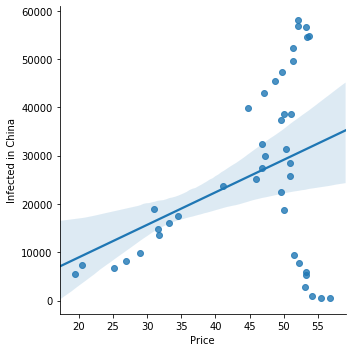

In [588]:
sns.lmplot(x='Price',y='Infected in China',data=wti)

In [587]:
wti.corr()

,Price,Infected in China
Price,1.000000,0.377296
Infected in China,0.377296,1.000000


### Global Mortality rates

In [116]:
nones = [None]*len(Countries)
d = dict(zip(Countries,nones))

for country in Countries:    
    d[country]= Pais(country).get_actual_mortality_rate()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


In [111]:
excluded_countries = list(Confirmed[Confirmed["3/23/20"]<200]['Country/Region'].unique())

In [117]:
global_mr = pd.DataFrame(data={"Mortality Rate":list(d.values())},
                         index=list(d.keys()))
#global_mr = global_mr.sort_values(ascending=False)

#for i in range(len(global_mr)):
#    print(str(i+1)+".- "+global_mr.index.to_list()[i] + ": " + str(global_mr[i]))

global_mr = global_mr.sort_values(by='Mortality Rate', ascending=False)
global_mr.drop(excluded_countries,axis=0,inplace=True)
global_mr.head(15)

,Mortality Rate
Italy,0.098589
Iraq,0.085443
Indonesia,0.080175
Iran,0.077949
Algeria,0.071970
Spain,0.070402
Philippines,0.063406
Egypt,0.049751
Japan,0.036044
Belgium,0.028578


In [120]:
global_mr['Mortality Rate'].mean()

0.019868207098475234